# Milestone 3: Investigate Project Questions

<hr style="clear:both">

Use this notebook for a quick start to the project. When a question is finished, extract it to multiple function callable from the website

**Project Mentor:** [Aoxiang Fan](https://people.epfl.ch/aoxiang.fan) ([Email](mailto:aoxiang.fan@epfl.ch))
**Authors:** [Luca Carroz](https://people.epfl.ch/emilie.carroz), [David Schroeter](https://people.epfl.ch/david.schroeter), [Xavier Ogay](https://people.epfl.ch/xavier.ogay), [Joris Monnet](https://people.epfl.ch/joris.monnet), [Paulo Ribeiro de Carvalho](https://people.epfl.ch/paulo.ribeirodecarvalho)

<hr style="clear:both">

## Import

In [10]:
# Import needed libraries
import os

import pandas as pd


# Load autoreload extension
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DataSet
Check that all data sets are already computed, if not please read `README.md` and follow steps for its creation.

In [11]:
folder_path = 'dataset/'
file_names = ['clean_enrich_movies.csv', 'spotify_composers_dataset.csv', 'mapping_locations_to_country.csv']
file_paths = [folder_path + file_name for file_name in file_names]
file_exist = [os.path.exists(file_path) for file_path in file_paths]

if all(file_exist):
    print(f"All files exist and are in the correct directory.")
else:
    print(
        f"At least one file doesn't exist. Please be sure to have the files and to locate them in the right directory (dataset/).")

All files exist and are in the correct directory.


## Load Data

Section to load the enriched and retrieved data.

In [12]:
spotify_composers_dataset = pd.read_pickle('dataset/spotify_composers_dataset.pickle')
clean_enrich_movies = pd.read_pickle('dataset/clean_enrich_movies.pickle')
location_to_country = pd.read_csv('dataset/mapping_locations_to_country.csv')

# display(clean_enrich_movies)

## Question 1

Which are the most frequent music genre appearing in movies ?

In [ ]:
from question_script.question1 import *

# Retrieve composer name out of the composer class to easily join spotify and movie dataframes
composers_to_movies = create_db_to_link_composers_to_movies(clean_enrich_movies)

In [ ]:
# TODO: Discuss about a possible interactive graph. The user can choose the range of box office revenue of movies and see the ranking with genre. GOAL: See if low, middle or high box office revenue have same ranking in music genre or not.

# Join spotify and movie dataset and choose the relevant attributes for question 1
movie_music_genre_df = pd.merge(left=spotify_composers_dataset,
                                right=composers_to_movies,
                                left_on='name',
                                right_on='composer_name',
                                how='inner')[['movie_name', 'genres', 'movie_revenue']]

question_1(movie_music_genre_df=movie_music_genre_df,
           min_revenue=0,
           max_revenue=int(1e12),
           soundtrack_in_genre=False)

## Question 2

What is the average composer's age at their :
   - first movie appearance ?
   - biggest box office revenue ?

### Average composer's age at their first movie appearance

In [4]:
from question_script.question2 import *
from question_script import question_helper

composer_dataframe_with_fst_appearance = calculate_composer_age_fst_appearance(clean_enrich_movies)

composer_fst_appearance_days, composer_fst_appearance_years = get_average_age_first_appearance(
    composer_dataframe_with_fst_appearance)

print("The average age of the composer at his first movie is:\n"
      f"\t- {composer_fst_appearance_years:.3f} years\n"
      f"\t- {composer_fst_appearance_days:.3f} days")

NameError: name 'clean_enrich_movies' is not defined

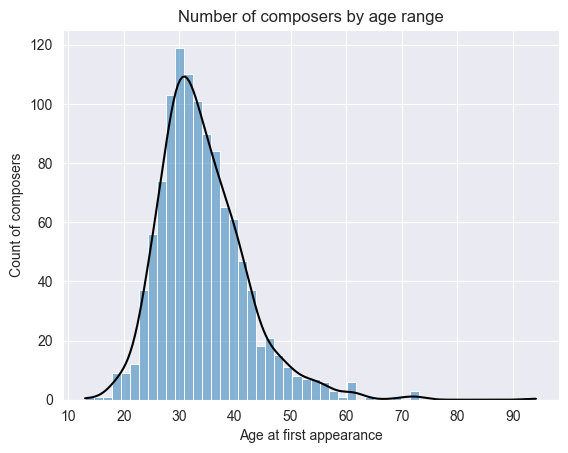

In [37]:
plot_composer_by_age_range(composer_dataframe_with_fst_appearance, 'c_age_first_appearance_years', bin_nb=50)

### Average composer's age at their biggest box office revenue

In [ ]:
composer_age_highest_box_office = calculate_composer_age_highest_box_office(clean_enrich_movies)

composer_age_high_box_office_days, composer_age_high_box_office_years = get_average_age_high_box_office(
    composer_age_highest_box_office)

print("The average age of the composer at his highest box office revenue is:\n"
      f"\t- {composer_age_high_box_office_years:.3f} years\n"
      f"\t- {composer_age_high_box_office_days:.3f} days")

In [ ]:
plot_composer_by_age_range(composer_age_highest_box_office, 'c_age_highest_revenue_years', bin_nb=50)

## Question 3

How the top composers' career progress over the years ?

In [24]:
import question_script.question_helper
from question_script.question3 import *

movie_renamed = prepare_data_for_q3()

display(movie_renamed.head())
print(movie_renamed.shape)

,release_year,composer_id,composer_name,box_office_revenue
0,2009,1729,James Horner,2.782275e+09
1,1997,1729,James Horner,2.185372e+09
2,2012,37,Alan Silvestri,1.511758e+09
3,2011,2949,Alexandre Desplat,1.328111e+09
4,2013,6041,Brian Tyler,1.215577e+09


(8505, 4)


C:\Users\Joris\AppData\Local\Temp\ipykernel_15952\2823498581.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



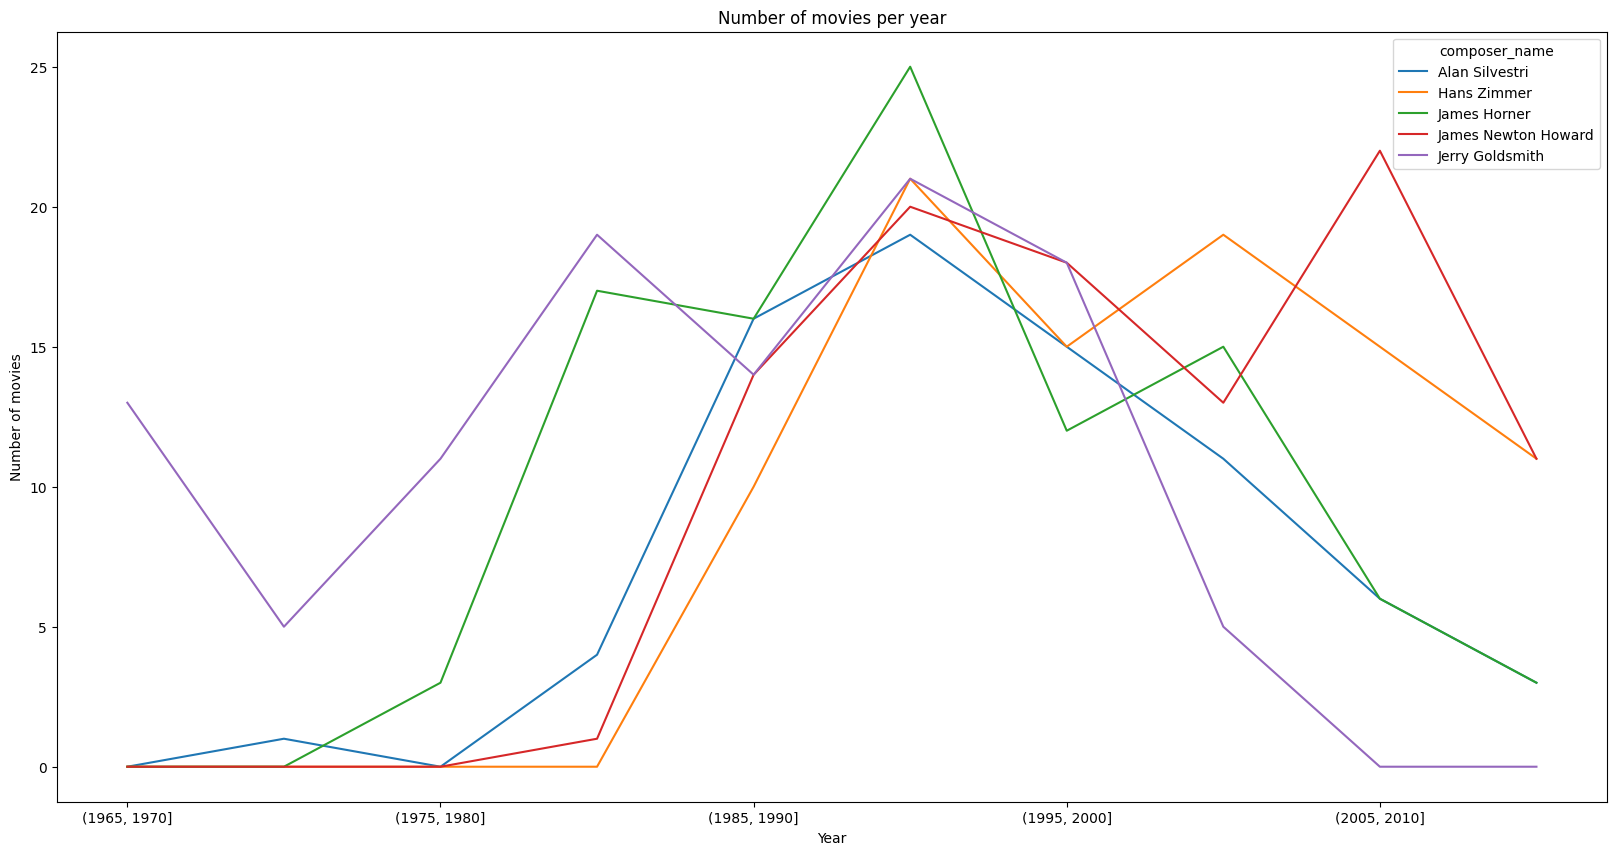

In [177]:
movie_grouped_by_top_composer = filter_by_top_composers(movie_renamed, 5)

import numpy as np
import matplotlib.pyplot as plt

# Change years to int
movie_grouped_by_top_composer.loc[:,'release_year'] = movie_grouped_by_top_composer['release_year'].astype(int)

# Define bins for years
bins = np.arange(movie_grouped_by_top_composer['release_year'].min(), movie_grouped_by_top_composer['release_year'].max() + 1, 5)

# Add a new column 'year_bin' to the DataFrame, indicating which bin each year falls into
movie_grouped_by_top_composer['year_bin'] = pd.cut(movie_grouped_by_top_composer['release_year'], bins)

# Group by composer and year bin, count the number of movies
movie_counts = movie_grouped_by_top_composer.groupby(['composer_name', 'year_bin'], observed=False).size()

# Unstack the 'composer_name' level to create a DataFrame
movie_counts_df = movie_counts.unstack(level='composer_name')

# Plot the data
movie_counts_df.plot(kind='line', figsize=(20, 10))

# Set the title and labels
plt.title('Number of movies per year')
plt.xlabel('Year')
plt.ylabel('Number of movies')

plt.show()

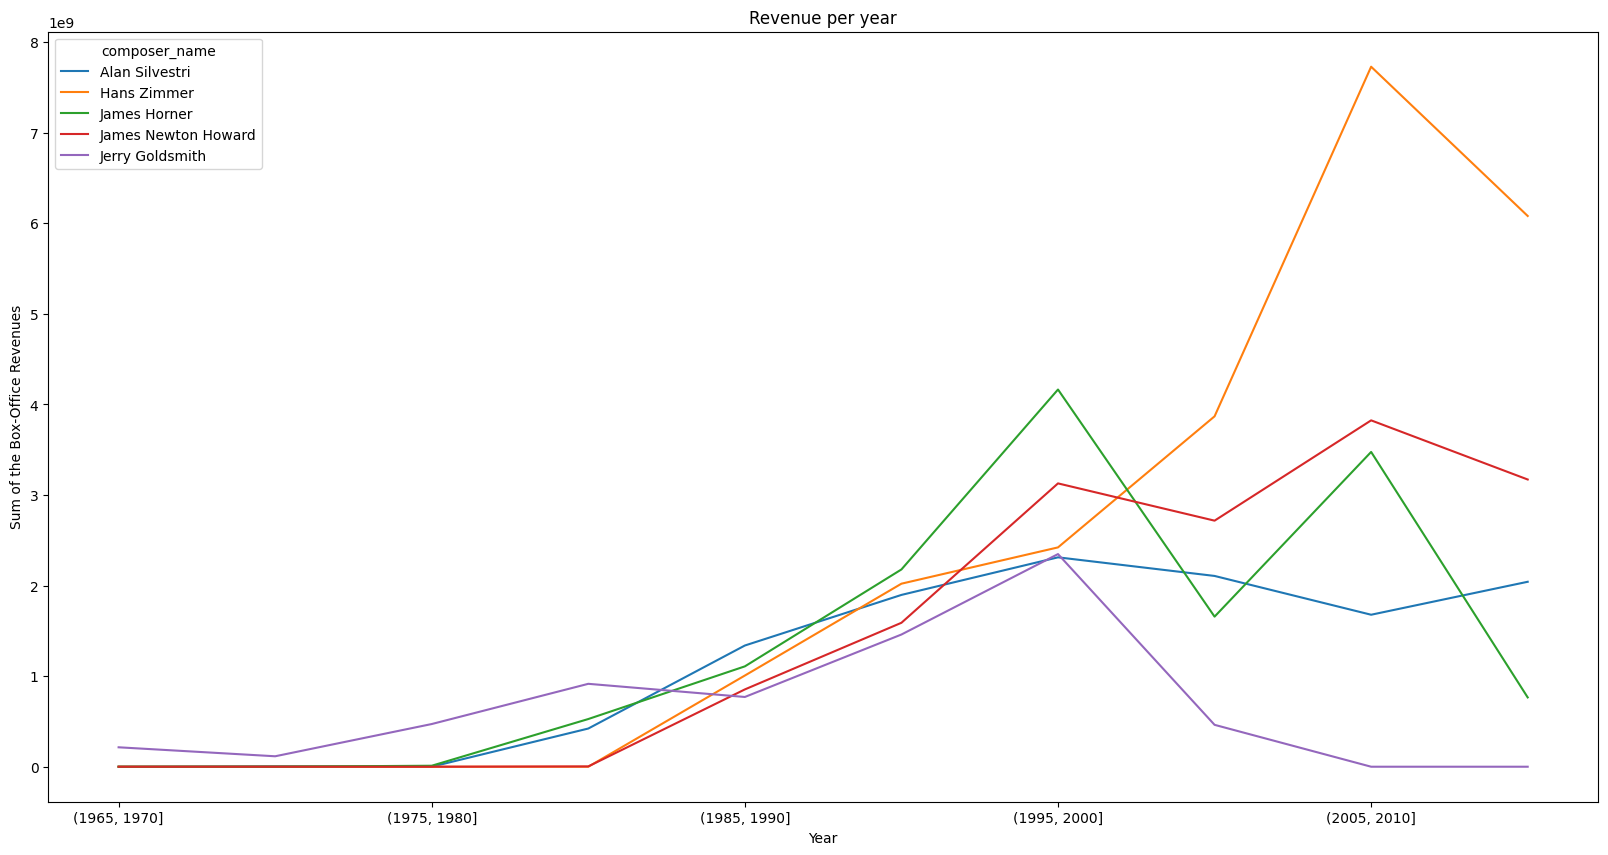

In [162]:
# Plot the evolution of the revenue for the film per year for the top composers
movie_revenue = movie_grouped_by_top_composer.groupby(['composer_name', 'year_bin'], observed=False)['box_office_revenue'].sum()
movie_revenue_df = movie_revenue.unstack(level='composer_name')
movie_revenue_df.plot(kind='line', figsize=(20, 10))
plt.title('Revenue per year')
plt.xlabel('Year')
plt.ylabel('Sum of the Box-Office Revenues')
plt.show()

## Question 4

Where do composers come from ?

In [ ]:
from question_script.question4 import *

# Use the already computed dataframe from q.1 to retrieve information like the place_of_birth of all composers
composer_place_of_birth_df = pd.merge(
    left=spotify_composers_dataset,
    right=composers_to_movies,
    left_on='name',
    right_on='composer_name',
    how='inner'
)[['composer_name', 'composer_place_of_birth', 'popularity']].drop_duplicates()  # note: few rows were duplicate

# Delete rows (composers) where we do not have the place of birth (i.e. None value)
composer_place_of_birth_df = composer_place_of_birth_df.query('composer_place_of_birth.notna()')

# Compute the number of composer per location within the selected range of composer's popularity
number_composer_per_location = composers_selection_over_popularity(
    df=composer_place_of_birth_df,
    min_popularity=0,
    max_popularity=100
).groupby('composer_place_of_birth').count()["composer_name"]

# For plot reasons, map all locations to its corresponding country and count again the number of composer
number_composer_per_country = pd.merge(
    left=number_composer_per_location,
    right=location_to_country,
    left_on='composer_place_of_birth',
    right_on='location',
    how='outer'
).groupby('country').count()["location"]

[link](https://plotly.com/python/builtin-colorscales/) to see different colors.

In [ ]:
heat_map_world(df=number_composer_per_country.reset_index(),
               color='peach')

## Question 5

Does composer's gender matter ?

In [ ]:
from question_script.question5 import *

# Get all movie composers
composers = get_cleaned_composers()
# Plot the number of Male vs Female movie composers
composers['gender'].value_counts().plot(kind='bar', figsize=(20, 10),
                                        title="Number of Male vs Female movie composers from 1915 to 2014")
plt.show()

Let's see how this ratio evolved over the years

In [ ]:
# Dataframe containing the number of composers for each year, grouped by their gender
gender_prop_by_year = pd.crosstab(index=composers['release_date'], columns=composers['gender'], normalize='index')
# Plot the dataframe
gender_prop_by_year.plot(kind='bar', stacked=True, color=['red', 'blue'], figsize=(20, 10))
plt.xticks(np.arange(-2, 96, 10))
plt.title('Proportion of Female vs Male composers across years')
plt.legend(loc="upper left", ncol=2)
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.show()

## Question 6

Does having a personal website correlate with the composers' success ?

In [ ]:
from question_script.question6 import *

a = get_composer_success_and_website()
a.boxplot(column='popularity', by='has_homepage', figsize=(20, 10))

## Question 7

Is there a correlation between box office revenue and movie's playlist popularity ?

In [ ]:
import question_script.question7 as q7

merged_df, pop_df = q7.get_merged_and_pop_df()

In [ ]:
q7.plot_popularity_histogram(pop_df)
q7.plot_popularity_histogram_matplt(pop_df)

In [ ]:
q7.plot_scatter_popularity_revenue_overall(merged_df)
q7.plot_scatter_popularity_revenue_overall_matplotlib(merged_df)

In [ ]:
q7.print_pearson_correlation(merged_df)

In [ ]:
q7.plot_scatter_popularity_revenue_by_year(merged_df)
q7.plot_scatter_popularity_revenue_by_year_matplotlib(merged_df)

In [ ]:
q7.plot_heatmap_correlation(merged_df)
q7.plot_heatmap_correlation_matplotlib(merged_df)